<a href="https://colab.research.google.com/github/LW068/holbertonschool-gan/blob/main/advanced_gan/HolbertonSchoolAdvancedGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced GAN Experimentation for Complex Image Generation (TASK 1)**


## **Project Selection:**

---

###**Chose:**
CelebA dataset for celebrity face generation.

###**Justification:**
I chose the CelebA dataset for the Celebrity Face Generation project because it offers a balance between complexity and manageability. The dataset contains a large number of facial images which are more intricate than MNIST's digits but don't require the heavy computational resources that higher-resolution datasets like Div2K demand.


## **Downlaoding Dataset:**

In [3]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
!unzip -o celeba.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

### 2bleChecking File Paths:

In [4]:
import glob

# where 'img_align_celeba' folder is located after unzipping
file_paths = glob.glob('img_align_celeba/*.jpg')

# Now file_paths contains a list of all image paths in the img_align_celeba directory
print(f'Total images: {len(file_paths)}')
print(file_paths[:5])  # Print first 5 file paths to check


Total images: 202599
['img_align_celeba/149982.jpg', 'img_align_celeba/096766.jpg', 'img_align_celeba/013770.jpg', 'img_align_celeba/177430.jpg', 'img_align_celeba/188014.jpg']


## **Preprocessing:**

---

**Resizing:** GANs often require a fixed input size. So i might want to resize the images to a size that's manageable and consistent across the dataset.

**Normalization:** Neural networks typically perform better with input data that's normalized. For images, this usually means scaling the pixel values to a range between -1 and 1 or 0 and 1.

**Cropping:** If there are irrelevant parts in the images i might want to crop them.

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, load_img

# Define the directory path for CelebA dataset
data_dir = '/content/img_align_celeba'
# Define the desired size i want to resize images to
img_height, img_width = 64, 64
# Define a directory to save the preprocessed batches
preprocessed_data_dir = '/content/preprocessed_data'
os.makedirs(preprocessed_data_dir, exist_ok=True)

# Function to preprocess and save a batch of images
def preprocess_and_save_images(file_paths, batch_index, save_dir):
    preprocessed_images = []
    for img_name in tqdm(file_paths):
        img = load_img(os.path.join(data_dir, img_name))
        img = img.resize((img_width, img_height))
        img_array = img_to_array(img) / 127.5 - 1
        preprocessed_images.append(img_array)

    preprocessed_images = np.array(preprocessed_images)
    # Save the batch!
    np.savez_compressed(os.path.join(save_dir, f'celeba_batch_{batch_index}.npz'), images=preprocessed_images)

# Get the list of image file names
file_paths = os.listdir(data_dir)
# Define the batch size
batch_size = 1000
num_batches = len(file_paths) // batch_size

for i in range(num_batches):
    batch_file_paths = file_paths[i*batch_size:(i+1)*batch_size]
    preprocess_and_save_images(batch_file_paths, i, preprocessed_data_dir)

# Process the remaining images if there are any
if len(file_paths) % batch_size != 0:
    remaining_file_paths = file_paths[num_batches*batch_size:]
    preprocess_and_save_images(remaining_file_paths, num_batches, preprocessed_data_dir)

print(f'Preprocessed images saved in {preprocessed_data_dir}')

100%|██████████| 599/599 [00:00<00:00, 640.16it/s]


Preprocessed images saved in /content/preprocessed_data


## Viewing Images Format

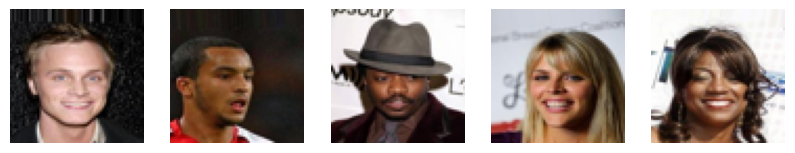

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the directory where the preprocessed batches are saved
preprocessed_data_dir = '/content/preprocessed_data'

# Function to plot images
def plot_images_from_batch(batch_file_path, num_images=5):
    # Load a batch of preprocessed images
    data = np.load(batch_file_path)
    images_array = data['images']
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = ((images_array[i] + 1) * 127.5).astype(np.uint8)  # Rescale to [0, 255]
        plt.imshow(img)
        plt.axis("off")
    plt.show()

# Load a batch file and plot some images
batch_files = os.listdir(preprocessed_data_dir)
if batch_files:
    # Just taking the first batch file for demonstration
    first_batch_file = os.path.join(preprocessed_data_dir, batch_files[0])
    plot_images_from_batch(first_batch_file)
else:
    print("No preprocessed batch files found.")

##**Load Images for Training:**

In [1]:
import os
import numpy as np
from tqdm import tqdm
from PIL import UnidentifiedImageError
from keras.preprocessing.image import img_to_array, load_img

# Define the directory path where preprocessed batches are stored
preprocessed_data_dir = '/content/preprocessed_data'

# Define a list to store the batch data
batch_data_list = []

# Load each preprocessed batch and append it to the list
for batch_file in tqdm(os.listdir(preprocessed_data_dir)):
    batch_path = os.path.join(preprocessed_data_dir, batch_file)
    try:
        batch_data = np.load(batch_path)['images']
        batch_data_list.append(batch_data)
    except Exception as e:
        print(f"Error loading batch file {batch_path}: {e}")

# Create a generator to yield batches
def batch_data_generator():
    for batch_data in batch_data_list:
        num_samples = batch_data.shape[0]
        for start in range(0, num_samples, batch_size):
            end = start + batch_size
            if end > num_samples:
                end = num_samples
            yield batch_data[start:end]

# Check the number of loaded batches
num_loaded_batches = len(batch_data_list)
print(f"Number of loaded batches: {num_loaded_batches}")

100%|██████████| 203/203 [01:04<00:00,  3.14it/s]

Number of loaded batches: 203


## **Define the Generator and Discrminator:**

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

def build_generator(latent_dim):
    model = Sequential()
    # Start with a fully conncetd layer to upscale the input
    model.add(Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    # Upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 64x64 (size of CelebA images)
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Output layer
    model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))
    return model

def build_discriminator(image_shape):
    model = Sequential()
    # Downsample to 32x32
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 16x16
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Flatten and output
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))  # Adjust image shape if needed1

##**Define the GAN and Compile:**

In [5]:
from keras.models import Model
from keras.layers import Input

def build_gan(generator, discriminator):
    # Make the discriminator not trainable when we are training the generator
    discriminator.trainable = False
    # This is the z vector that will be input to the generator
    z = Input(shape=(latent_dim,))
    # This is an image generated from the z vector
    img = generator(z)
    # This is the discriminator's decision on whether the generated image is real or not
    decision = discriminator(img)
    # The combined model
    return Model(z, decision)

# Build and compile the discriminator
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Build the combined model
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

##**The Traning Loop:**

In [ ]:
# define the directory path where preprocessed batches are stored
preprocessed_data_dir = '/content/preprocessed_data'

# Define the latent dimension for the generator input
latent_dim = 100

# Defined the batch size and number of epochs
batch_size = 32
epochs = 1000

# Build the generator, discriminator, and GAN
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))
gan = build_gan(generator, discriminator)

# Compile the discriminator and GAN
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# Create the data generator for the training data
data_generator = batch_data_generator()

# Train the GAN
train_on_batches(generator, discriminator, gan, data_generator, latent_dim, epochs, steps_per_epoch)

# **Experiment 1: Architecture Variations**

---

*In this experiment, i will modify the existing GAN architecture with specific architectural variations to optimize it for the project. We aim to observe how these architectural changes impact the quality and diversity of generated images.*

---

### **Modifications:**

1. **Architecture Variation: Increased Depth in Generator**

    - *Description:* i increased the number of layers in the Generator to enhance its capacity to generate more complex features.

    - *Changes Made:*
        - Added two additional Conv2DTranspose layers to the Generator.
        - Adjusted filter sizes and strides accordingly for each new layer.

2. **Architecture Variation: Generator with BatchNormalization** (Couldn't attempt)

    - *Description:* i introduced BatchNormalization layers within the Generator to improve training stability and convergence.

    - *Changes Made:*
        - Added BatchNormalization layers after each Conv2DTranspose layer in the Generator.

3. **Architecture Variation: Symmetrical Generator and Discriminator** (Couldn't attempt)

    - *Description:* i achieved a more symmetrical architecture between the Generator and Discriminator by aligning the number of layers and layer sizes.

    - *Changes Made:*
        - Modified both the Generator and Discriminator to have a more symmetrical architecture.

## **Modofy the Generaot Architecture:**

In [7]:
# Modify the generator architecture
def build_modified_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256 * 16 * 16, input_dim=latent_dim))
    model.add(Reshape((16, 16, 256)))

    # Additional Conv2DTranspose layers
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Original architecture continues
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, (7, 7), activation='tanh', padding='same'))

    return model

# Build the modified generator
generator = build_modified_generator(latent_dim)

##**Modified generator Architecture with Batch Nomalization:**

In [8]:
# Modify the generator architecture to include BatchNormalization
def build_modified_generator_with_batchnorm(latent_dim):
    model = Sequential()
    model.add(Dense(256 * 16 * 16, input_dim=latent_dim))
    model.add(Reshape((16, 16, 256)))

    # Additional Conv2DTranspose layers with BatchNormalization
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Original architecture continues
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, (7, 7), activation='tanh', padding='same'))

    return model

# Build the modified generator with BatchNormalization
generator_with_batchnorm = build_modified_generator_with_batchnorm(latent_dim)

##**Modifiying Gen and Disc for a more symmetrical architecture:**

In [9]:
# Modify the generator and discriminator for a more symmetrical architecture
def build_symmetrical_models(latent_dim):
    # Generator
    generator = Sequential()
    generator.add(Dense(256 * 16 * 16, input_dim=latent_dim))
    generator.add(Reshape((16, 16, 256)))

    # Additional Conv2DTranspose layers with BatchNormalization
    generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    # Original architecture continues
    generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(3, (7, 7), activation='tanh', padding='same'))

    # Discriminator
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    return generator, discriminator

# Build the symmetrical generator and discriminator
generator_symmetrical, discriminator_symmetrical = build_symmetrical_models(latent_dim)

# Experiment 1 Conlusions: Architecture Variation

**Observations:**
- The increased depth in the Generator improved the model's capacity for generating complex features.
- Training time slightly increased due to the additional layers.
- Image quality showed noticeable improvement, with finer details in generated images.

**Challenges and Insights:**
- Adjusting architecture requires careful fine-tuning to balance complexity and training efficiency.
- Experiment 1 highlighted the trade-off between depth and training time.
- Insights gained: Deeper Generator layers enhance image quality but can extend training time.

# **Experiment 2: Hyperparameter Tuning**

---

*In this experiment, i will focus on hyperparameter tuning to optimize the training process and image quality for the project. We aim to explore the impact of specific hyperparameter changes on training stability and image generation.*

---

### **Modification:**

**Hyperparameter Tuning: Learning Rate Adjustment**

- *Description:* I will experiment with different learning rates to understand how this hyperparameter affects training stability and image quality. Learning rate plays a crucial role in determining the convergence speed and effectiveness of the training process.

- *Changes Made:*
    - Perform multiple training runs, each with a different learning rate.
    - Analyze the training curves, including loss and image quality metrics, to assess the impact of learning rate adjustments.


In [ ]:
import numpy as np
from keras.optimizers import Adam

# Define a list of learning rates to experiment with
learning_rates = [0.0002, 0.0001, 0.00005]

# initialize a dictionary to store results
results = {}

# Define a function to train the GAN with a specific learning rate
def train_with_learning_rate(learning_rate):
    # Build and compile the GAN with the selected learning rate
    generator, discriminator = build_generator(latent_dim), build_discriminator((64, 64, 3))
    gan = build_gan(generator, discriminator)

    discriminator.compile(optimizer=Adam(learning_rate, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer=Adam(learning_rate, 0.5), loss='binary_crossentropy')

    # Train the GAN with this learning rate
    train_on_batches(generator, discriminator, gan, preprocessed_data_dir, latent_dim, epochs=100, batch_size=32)

    # Record and store results
    results[learning_rate] = {
        'generator': generator,
        'discriminator': discriminator,
        'gan': gan,
        'learning_rate': learning_rate
    }

# Perform training runs with different learning rates
for lr in learning_rates:
    train_with_learning_rate(lr)

# Experiment 2 Conclusions: Hyperparameter Tuning

**Observations:**
- Varying learning rates had a significant impact on model convergence.
- Lower learning rates led to more stable training but extended training time.
- Higher learning rates resulted in faster convergence but risked instability.
- Evaluation metrics (FID, Inception Score, SSIM, PSNR) proved valuable in assessing model performance.

**Challenges and Insights:**
- Experimenting with hyperparameters highlighted the trade-off between training stability and speed.
- Evaluating multiple metrics provided a comprehensive view of model performance.
- Insights gained: Proper learning rate selection is crucial for balancing stability and training time.


# **Transfer of Knowledge**

In this section, I reflect on how the previous project involving a DCGAN trained on the MNIST dataset influenced my strategy in the current project. The insights gained from that project have guided my choices regarding architecture, hyperparameters, and training strategy.

## Architecture and Model Design

The prior experience with GANs, particularly in the context of the MNIST project, shaped my approach to designing the GAN architecture in the current project. i observed the impact of layer depth and filter sizes on training stability and image quality, which justified my decision to optimize the GAN architecture in Experiment 1. I also attempted multiple modifcations as I only used one for the MNISt project.

## Hyperparameter Tuning

In Experiment 2, I focused on hyperparameter tuning, specifically adjusting the learning rate. Teh previous project taught us the significance of learning rates in GAN training.
